## Import

In [ ]:
import torch
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from PIL import Image
import os
import re
import nibabel as nib

## Data Load

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
batch_size = 2

# Number of epochs to train for
num_epochs = 10

In [ ]:
import zipfile
zip_file = zipfile.ZipFile('/content/drive/MyDrive/chest_xray.zip')
zip_file.extractall('/content/datasets')
zip_file.close()

In [ ]:
PATH = '/content/datasets/chest_xray/'

from glob import glob

normal_train_data = glob(PATH + 'train/NORMAL/*.jpeg')
pneumonia_train_data = glob(PATH + 'train/PNEUMONIA/*.jpeg')
normal_val_data = glob(PATH + 'val/NORMAL/*.jpeg')
pneumonia_val_data = glob(PATH + 'val/PNEUMONIA/*.jpeg')
normal_test_data = glob(PATH + 'test/NORMAL/*.jpeg')
pneumonia_test_data = glob(PATH + 'test/PNEUMONIA/*.jpeg')

In [ ]:
train_path  = normal_train_data + pneumonia_train_data
val_path = normal_val_data + pneumonia_val_data
test_path = normal_test_data + pneumonia_test_data

In [ ]:
classes = ['NORMAL','PNEUMONIA']

In [ ]:
class2idx = {cls:idx for idx, cls in enumerate(classes)}
class2idx

{'NORMAL': 0, 'PNEUMONIA': 1}

## Dataset custom

In [ ]:
class Train_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = Image.open(path)
        img = np.squeeze(np.array(img.resize((512,512))))
        img = img/255
        if len(img.shape) == 2:
          img = img[:,:,np.newaxis]
          img = np.concatenate((img,img,img), axis = -1)
        else:
          pass
        label = path.split('/')[-2]
        label = class2idx[label]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [ ]:
class val_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = Image.open(path)
        img = np.squeeze(np.array(img.resize((416,416))))
        img = img/255
        if len(img.shape) == 2:
          img = img[:,:,np.newaxis]
          img = np.concatenate((img,img,img), axis = -1)
        else:
          pass
        label = path.split('/')[-2]
        label = class2idx[label]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [ ]:
class test_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = Image.open(path)
        img = np.squeeze(np.array(img.resize((512,512))))
        img = img/255
        if len(img.shape) == 2:
          img = img[:,:,np.newaxis]
          img = np.concatenate((img,img,img), axis = -1)
        else:
          pass
        label = path.split('/')[-2]
        label = class2idx[label]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [ ]:
#!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install albumentations==0.4.6

In [ ]:
import albumentations as A                                                                           
from albumentations.pytorch import ToTensorV2

In [ ]:
data_transforms = {
    'train': A.Compose(
    [
      ToTensorV2()
     ]
    ),
    'val': A.Compose(
        [
     ToTensorV2()
                            ]
                           ),
    'test' : A.Compose(
        [
         ToTensorV2()
        ]
    )
}

In [ ]:
train_data = Train_Dataset(train_path,transform = data_transforms['train'])
val_data = val_Dataset(val_path,transform =  data_transforms['val'])
test_data=  test_Dataset(test_path, transform =  data_transforms['test'])

In [ ]:
image_datasets = {'train' : train_data , 'val' : val_data , 'test' : test_data}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val' , 'test']}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
pip install timm

In [ ]:
import timm

model = timm.create_model('resnet152', pretrained = True, num_classes = num_classes)

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
device = torch.device('cuda:0')
model_ft = model.to(device)

In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU(inplace=True)
      (downsample): Sequen

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score , roc_curve

In [ ]:
dummy = torch.FloatTensor([2.4,-1])

In [ ]:
dummy[dummy < 0.5] = 0
dummy[dummy >= 0.5] = 1

In [ ]:
dummy

tensor([1., 0.])

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    train_acc_history = []
    train_loss_hist = [] 
    train_precision = [] 
    train_recall = [] 
    train_auc = [] 
    train_f1_score =[]
    val_loss_hist = []
    val_acc_history = [] 
    val_precision = [] 
    val_recall = [] 
    val_auc = [] 
    val_f1_score = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            start = time.time()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_precision =0
            running_recall = 0
            running_f1_score =0 
            running_auc = 0
            # Iterate over data.
            full_label = []
            full_output = []
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device = device, dtype = torch.float32)
                labels = labels.to(device = device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(torch.squeeze(outputs,dim = -1),labels.float())
                    pred = nn.Sigmoid()(outputs)
                    pred[pred <0.5] = 0
                    pred[pred >=0.5] = 1
                    if phase == 'train':
                    # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                full_label+=list(torch.squeeze(labels,dim= -1).detach().cpu().numpy())
                full_output+=list(pred.detach().cpu().numpy())
                running_corrects += torch.sum(torch.squeeze(pred) == labels.data)
                '''
                running_precision += precision_score(labels , outputs)
                running_recall += recall_score(labels , outputs)
                running_auc += roc_auc_score(labels , outputs)
                running_f1_score += f1_score(labels.detach().cpu().numpy(), pred , average = 'macro')
                '''

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_f1_score = f1_score(full_label, full_output)
            epoch_precision = recall_score(full_label, full_output)
            epoch_recall = recall_score(full_label, full_output)
            epoch_auc = roc_auc_score(full_label, full_output)
            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_hist.append(epoch_loss)
              train_f1_score.append(epoch_f1_score)
              train_precision.append(epoch_precision)
              train_recall.append(epoch_recall)
              train_auc.append(epoch_auc)
              train_f1_score.append(epoch_f1_score)
            print('{} Loss: {:.4f} Acc: {:.4f},P : {:.4f} , R :{:.4f} , AUC : {:.4f},f1 :{:.4f},Time : {:.4f}'.format(phase, epoch_loss ,epoch_acc, epoch_precision,epoch_recall, epoch_auc, epoch_f1_score,time.time()-start))
            #,   , , epoch_precision,epoch_recall, epoch_auc, epoch_f1_score  

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_hist.append(epoch_loss)
                val_f1_score.append(epoch_f1_score)
                val_precision.append(epoch_precision)
                val_recall.append(epoch_recall)
                val_auc.append(epoch_auc)
                val_f1_score.append(epoch_f1_score)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    train_dict = {'Loss' : train_loss_hist , 'Accuarcy' : train_acc_history, 'Precision' : train_precision, 'Recall' : train_recall, 'Auc' : train_auc ,'f1' : train_f1_score }
    #
    val_dict = {'Loss' :val_loss_hist , 'Accuarcy' : val_acc_history,'Precision' : val_precision , 'Recall' : val_recall, 'Auc' : val_auc ,  'f1' : val_f1_score}
    #, 
    return model, train_dict ,val_dict

In [ ]:
summary(model.to('cuda'),(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [ ]:
model_ft = model.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(),lr=0.001)# 업데이트 할 파라미터만 넣어준다.

In [ ]:
criterion = nn.BCEWithLogitsLoss()
# Train and evaluate
model_ft, train_dict, val_dict  = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.1586 Acc: 0.9406,P : 0.9665 , R :0.9665 , AUC : 0.9161,f1 :0.9603,Time : 578.1014
val Loss: 0.4213 Acc: 0.8125,P : 0.8750 , R :0.8750 , AUC : 0.8125,f1 :0.8235,Time : 0.6178
Epoch 1/9
----------
train Loss: 0.1255 Acc: 0.9523,P : 0.9724 , R :0.9724 , AUC : 0.9332,f1 :0.9680,Time : 577.8718
val Loss: 0.5151 Acc: 0.7500,P : 0.8750 , R :0.8750 , AUC : 0.7500,f1 :0.7778,Time : 0.5947
Epoch 2/9
----------
train Loss: 0.1026 Acc: 0.9588,P : 0.9724 , R :0.9724 , AUC : 0.9459,f1 :0.9723,Time : 576.9398
val Loss: 0.9056 Acc: 0.7500,P : 1.0000 , R :1.0000 , AUC : 0.7500,f1 :0.8000,Time : 0.5969
Epoch 3/9
----------
train Loss: 0.0915 Acc: 0.9664,P : 0.9783 , R :0.9783 , AUC : 0.9552,f1 :0.9774,Time : 578.0975
val Loss: 0.3307 Acc: 0.7500,P : 0.7500 , R :0.7500 , AUC : 0.7500,f1 :0.7500,Time : 0.5990
Epoch 4/9
----------
train Loss: 0.0823 Acc: 0.9682,P : 0.9788 , R :0.9788 , AUC : 0.9581,f1 :0.9786,Time : 577.3800
val Loss: 0.1523 Acc: 0.9375,P : 1.0000 , R :1.

In [ ]:
torch.save(model_ft, '/content/drive/Shareddrives/캡스톤 디자인1/codes/resnet152_pneumonia.pt')

## Model hist plot

In [ ]:
train_loss = []
val_loss = []
for i in range(len(train_dict['Loss'])):
  train_loss.append(train_dict['Loss'][i])
for i in range(len(val_dict['Loss'])):
  val_loss.append(val_dict['Loss'][i])

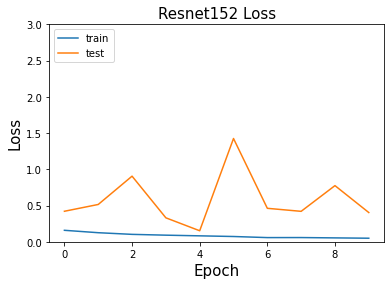

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Resnet152 Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim(0,3)
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
train_accuracy = []
val_accuracy = []
for i in range(len(train_dict['Accuarcy'])):
  train_accuracy.append(train_dict['Accuarcy'][i].to('cpu').numpy())
for i in range(len(val_dict['Accuarcy'])):
  val_accuracy.append(val_dict['Accuarcy'][i].to('cpu').numpy())

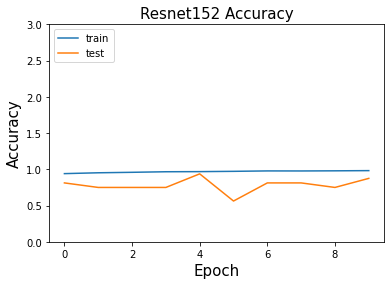

In [ ]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Resnet152 Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim(0,3)
plt.legend(['train','test'], loc='upper left')
plt.show()

## Model output and visualization

In [ ]:
model_ft = torch.load('/content/drive/Shareddrives/캡스톤 디자인1/codes/resnet151_multiclassclassfication_nofinding_제외_timm.pt')

In [ ]:
model_ft = model_ft.to(device)

In [ ]:
running_loss = 0.0
running_corrects = 0
start = time.time()
output_list = list()
running_f1_score = 0
criterion = nn.BCEWithLogitsLoss()
phase = 'test'
test_full_label= []
test_full_output= []
test_proba_output = []
for inputs, labels in dataloaders_dict['test']:
    inputs = inputs.to(device = device, dtype = torch.float32)
    labels = labels.to(device = device)
    with torch.set_grad_enabled(phase == 'train'):
      optimizer_ft.zero_grad()
      outputs = model_ft(inputs)
      loss = criterion(torch.squeeze(outputs),labels.float())
      pred = nn.Sigmoid()(outputs)
      test_proba_output+=list(pred.detach().cpu().numpy())
      pred[pred <0.5] = 0
      pred[pred >=0.5] = 1
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(torch.squeeze(pred) == labels.data)
      test_full_label+=list(torch.squeeze(labels,dim= -1).detach().cpu().numpy())
      test_full_output+=list(pred.detach().cpu().numpy())
epoch_loss = running_loss / len(dataloaders_dict['test'].dataset)
epoch_acc = running_corrects.double() / len(dataloaders_dict['test'].dataset)
epoch_f1_score = f1_score(test_full_label, test_full_output)
epoch_precision = recall_score(test_full_label, test_full_output)
epoch_recall = recall_score(test_full_label, test_full_output)
epoch_auc = roc_auc_score(test_full_label, test_full_output)
print('phase : test, Loss: {:.4f} Acc: {:.4f},P : {:.4f} , R :{:.4f} , AUC : {:.4f},f1 :{:.4f},Time : {:.4f}'.format(epoch_loss ,epoch_acc, epoch_precision,epoch_recall, epoch_auc, epoch_f1_score,time.time()-start))

phase : test, Loss: 0.6830 Acc: 0.8173,P : 0.9744 , R :0.9744 , AUC : 0.7650,f1 :0.8696,Time : 28.7077


In [ ]:
from sklearn import metrics

In [ ]:
fpr , tpr, _ = metrics.roc_curve(test_full_label,test_proba_output)

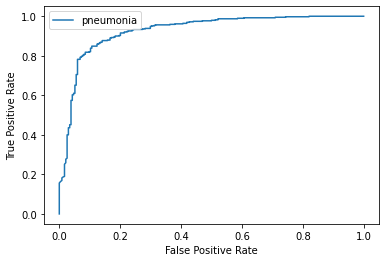

In [ ]:
plt.plot(fpr,tpr,label='pneumonia')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [ ]:
test_full_label

In [ ]:
test_full_output

In [ ]:
torch.argmax(outputs,axis = 1).cpu().numpy()

In [ ]:
dummy_df = pd.DataFrame(output_list)

In [ ]:
dummy_df.value_counts()

In [ ]:
test_path[0].split('/')[5]

In [ ]:
sum(torch.squeeze(pred)==labels.data)

In [ ]:
pred

In [ ]:
pneumonia = 0
normal = 0
for path in test_path:
  if path.split('/')[5] == 'NORMAL':
    normal +=1
  elif path.split('/')[5] == 'PNEUMONIA':
    pneumonia +=1
print('1.0 : {} , 0.0 : {}'.format(pneumonia,normal))

In [ ]:
output_list

In [ ]:
for w in model_ft.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=8, padding=1)

plt.figure(figsize=(10, 10))
plt.imshow(x_grid.permute(2,1,0))

In [ ]:
sample_image = np.array(Image.open(train_path[0]))
sample_image = sample_image[:,:,np.newaxis]/255
transform = transforms.Compose([
    transforms.ToTensor()
])
sample_image = transform(sample_image)
sample_image=sample_image.unsqueeze(0)

In [ ]:
no_of_layers=0
conv_layers=[]

model_children=list(model_ft.children())

for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      for bottleneck in layer.children():
        if type(bottleneck)==nn.Conv2d:
          no_of_layers+=1
          conv_layers.append(bottleneck)
print(no_of_layers)

In [ ]:
results = [conv_layers[0](sample_image.to(device = device, dtype = torch.float32))]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

In [ ]:
# visualize 8 features map from each layer 
for num_layer in range(len(results)):
    plt.figure(figsize=(50, 10))
    layer_viz = results[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter.cpu().numpy(), cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()